# Lab1 — Part 2: Training on MNIST

**Course**: Deep Learning for Image Analysis

**Class**: M2 IASD App  

**Professor**: Mehyar MLAWEH

---

In this part, we move from a **toy dataset** to a **real image dataset**.  
We will train a neural network on **MNIST**, **without using CNNs**.

The goal is to understand **why CNNs are needed**, not to use them yet.


## Learning objectives

After this part, you should understand:
- How images are represented as **vectors**
- How a neural network processes image data
- How multi-class classification works
- Why fully-connected networks are **not optimal** for vision tasks


## 0) Environment setup

Make sure you are using **GPU**:
- Runtime → Change runtime type → GPU


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 1) Imports


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms


## 2) The MNIST dataset

MNIST contains **handwritten digit images**:
- Image size: **28 × 28**
- Number of channels: **1 (grayscale)**
- Number of classes: **10** (digits 0–9)

Each image is originally a **2D grid of pixels**, but a fully-connected network
expects a **vector** as input.

https://www.youtube.com/watch?v=SrT6QkQUH4Q

### 🔍 Question (conceptual)

- How many pixels does one MNIST image contain? 28 * 28 pixels
- What will be the size of the input vector after flattening? 28 * 28


In [6]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

len(train_dataset), len(test_dataset)


(60000, 10000)

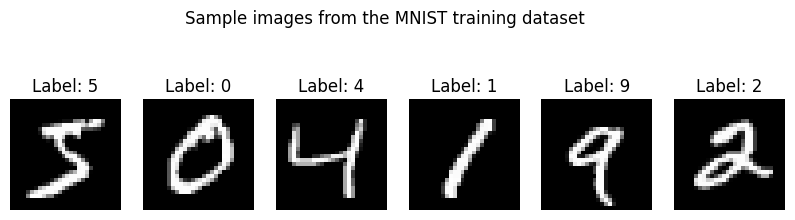

In [7]:
num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


## 3) DataLoader and mini-batches

We use **mini-batches** to train efficiently.

⚠️ Choosing the batch size is a trade-off between speed and memory.


In [8]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 4) Model: Fully-connected neural network (MLP)

### Two experiments with the same model

In this part, we train **the same neural network (MLP)** on two versions of MNIST:

1. **Original MNIST** (centered digits)
2. **Transformed MNIST** (shifted and rotated digits)

#### Experiment 1: MNIST (baseline)

1. **Flatten** the image `(1, 28, 28)` → `(784,)`
2. Feed it to a standard MLP

Architecture:
- Input: 784
- Hidden layer: 256 neurons + ReLU
- Output: 10 neurons (one per class)

The output represents **class scores (logits)**.



In [9]:
class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_MNIST().to(device)
model


MLP_MNIST(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

### ✅ TODO — Understanding the model

1. How many parameters does this model have?
2. Which layer contains most of the parameters?
Explain briefly.


**Answer:**

1. **Number of parameters:**
   - First layer (Linear 784→256): (784 × 256) + 256 = **200,960 parameters**
   - Second layer (Linear 256→10): (256 × 10) + 10 = **2,570 parameters**
   - **Total: 203,530 parameters**

2. **Layer with most parameters:** The first linear layer contains ~98% of all parameters (200,960 / 203,530).

   **Explanation:** The first layer has to connect every pixel of the input image (784 pixels) to 256 hidden neurons, resulting in 784 × 256 = 200,704 weights plus 256 biases. This is much larger than the second layer which only connects 256 neurons to 10 output classes.

 **Loss function and optimizer**

This is a **multi-class classification** problem.

- We use `CrossEntropyLoss`
- It combines **Softmax + Negative Log-Likelihood**


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



**Training loop**

The training logic is **exactly the same** as before.
Only the data and the model changed.


In [12]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


Epoch 1/5 - Loss: 0.0815
Epoch 2/5 - Loss: 0.0630
Epoch 3/5 - Loss: 0.0513
Epoch 4/5 - Loss: 0.0410
Epoch 5/5 - Loss: 0.0330


**Evaluation on the test set**

We compute the **classification accuracy**.


In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
accuracy


0.978

#### Experiment 2: Shifted and rotated MNIST

We now apply random shifts and rotations to the training images.

This breaks the assumption that digits are always centered and aligned.

The **model architecture remains exactly the same**.


In [14]:
transform_augmented = transforms.Compose([
    transforms.RandomAffine(
        degrees=50,
        translate=(0.2, 0.2)
    ),
    transforms.ToTensor()
])

train_dataset_aug = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform_augmented
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_dataset_aug), len(test_dataset)


(60000, 10000)

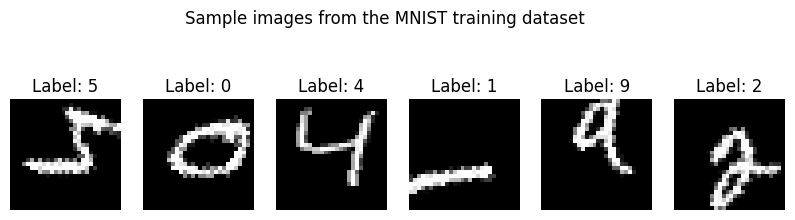

In [15]:

num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset_aug[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


Train the **same model** using the augmented training dataset.

Compare:
- Training loss
- Test accuracy

with the results obtained using original MNIST.


In [16]:
# Train on augmented MNIST
model_aug = MLP_MNIST().to(device)
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=1e-3)

epochs = 5

for epoch in range(epochs):
    model_aug.train()
    running_loss = 0.0

    for images, labels in train_loader_aug:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_aug.zero_grad()
        outputs = model_aug(images)
        loss = criterion_aug(outputs, labels)

        loss.backward()
        optimizer_aug.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_aug)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

Epoch 1/5 - Loss: 1.2475
Epoch 2/5 - Loss: 0.7123
Epoch 3/5 - Loss: 0.5859
Epoch 4/5 - Loss: 0.5309
Epoch 5/5 - Loss: 0.4827


In [17]:
# Evaluate on test set
model_aug.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_aug(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_aug = correct / total
print(f"Test Accuracy (Augmented MNIST): {accuracy_aug:.4f} ({accuracy_aug*100:.2f}%)")

# Note: You should compare this with the baseline accuracy from Experiment 1

Test Accuracy (Augmented MNIST): 0.8990 (89.90%)


## 5) What do we observe? (Reflection)

 - Why does the same fully-connected model perform worse on shifted and rotated MNIST images compared to vanilla MNIST?

 - What limitation of fully-connected networks does this experiment reveal when dealing with images?

- Based on these results, what properties should a better model for image data have?

✍️ Write short answers (2–3 lines).


**Answers:**

**1. Why does the MLP perform worse on shifted/rotated MNIST?**

Fully-connected networks treat each pixel as an independent feature and have no understanding of spatial relationships. When a digit is shifted or rotated, the same visual pattern (e.g., the curve of a "3") activates completely different input neurons. The network must learn to recognize each digit separately for every possible position and orientation, which is extremely inefficient and requires much more data.

**2. What limitation does this reveal?**

This experiment reveals that MLPs lack **translation invariance** and **spatial awareness**. They cannot generalize patterns learned at one location to another location in the image. Each neuron in the first layer connects to a fixed pixel position, so moving the digit by even one pixel completely changes which neurons are activated.

**3. What properties should a better model have?**

A better model for image data should have:
- **Translation invariance**: Ability to recognize the same pattern regardless of its position in the image
- **Local connectivity**: Focus on local spatial neighborhoods rather than connecting to all pixels
- **Parameter sharing**: Use the same feature detectors across different regions of the image
- **Hierarchical feature learning**: Build complex features from simple ones (edges → shapes → objects)

These properties are exactly what **Convolutional Neural Networks (CNNs)** provide, which is why they dramatically outperform MLPs on vision tasks.

## 6) Looking ahead — why CNNs?

In the next assignment, we will replace this MLP with **Convolutional Neural Networks**.

CNNs:
- Exploit **spatial structure**
- Share parameters
- Achieve **much higher accuracy** on image tasks

👉 You should expect a **significant accuracy improvement** in the next assignment.
